In [1]:
date()

[1] "Thu Nov 24 12:57:00 2016"

# 8章 マルコフ連鎖モンテカルロ（MCMC）法とベイズ統計モデル

* マルコフ連鎖: 現在の状態が一つ前の状態で決まる
* モンテカルロ: 確率的シミュレーション

## 8.1 例題: 種子の生存確率（個体差なし）

In [2]:
sapply(c("pipeR", "dplyr", "tidyr", "ggplot2", "readr"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE

例題データ: 植物個体の8個の種子の生死を20個体について調べた

In [3]:
load("data/chap08/data.RData")
# or
# data <- c(4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4)
str(data)

 num [1:20] 4 3 4 5 5 2 3 1 4 0 ...


頻度分布は，

In [4]:
table(data)

data
0 1 2 3 4 5 6 
1 2 1 3 6 6 1 

合計生存種子数

In [5]:
sum(data)

[1] 73

図示すると，

In [6]:
options(repr.plot.width = 4, repr.plot.height = 4)

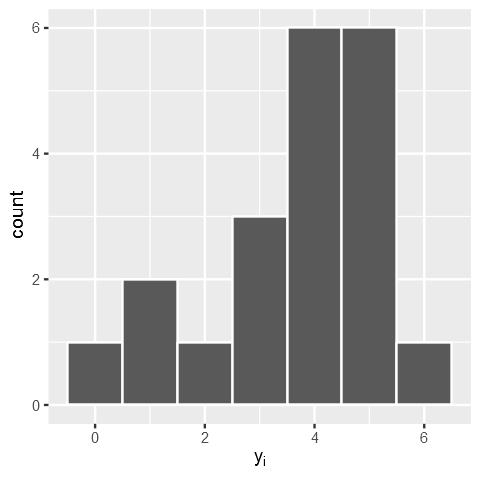

In [7]:
ggplot(data_frame(x = c(0, 8)), aes(x)) + 
    geom_histogram(data = data_frame(y = data), mapping = aes(x = y), binwidth = 1, colour = "white") + 
    xlab(expression("y"[i]))

生存種子数 $y_i$ が二項分布に従うと仮定する．

生存確率 $q$ で個体 $i$ の8個中で生存数が $y_i$ である確率は

$$ p(y_i | q) = \binom{8}{y_i} q^{y_i}(1 - q)^{8 - y_i} $$

となり，尤度は

$$ L(q) = p(\boldsymbol{Y} | q) = \prod\limits_i p(y_i | q) $$

であり，対数尤度は

$$ \log L(q) = \sum\limits_i \{ y_i \log q + (8 - y_i) \log(1 - q) \} + \mathrm{C} $$

となる（$\mathrm{C}$は$q$によらない定数）.

対数尤度を求める関数 `logL(q, y)`

In [8]:
logL <- function(q, y){
    sum(y * log(q) + (8 - y) * log(1 - q) + log(choose(8, y)))
}

In [9]:
logL(0.46, data)

[1] -37.75237

対数尤度関数は，次のような形になる

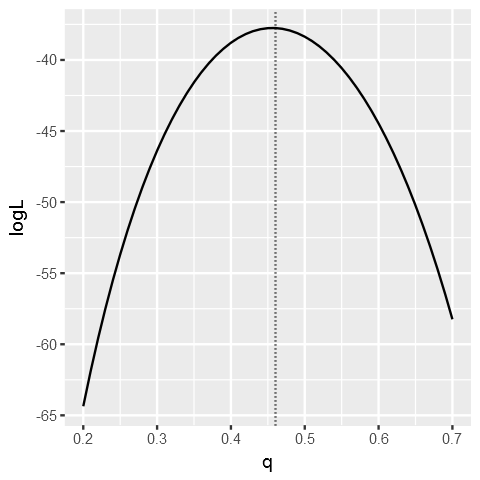

In [10]:
data_frame(q = seq(0.2, 0.7, 0.01)) %>>% 
    mutate(logL = sapply(q, function(x){logL(x, data)})) %>>% 
    ggplot(aes(x = q, y = logL)) + 
    geom_line() + 
    geom_vline(xintercept = 0.46, linetype = "dotted")

$q$ で微分して`logL` の傾きが0になる点 $\hat{q}$ を求めると，

$$ \hat{q} = \frac{\text{合計生存種子数}}{\text{合計調査種子数}} = \frac{\sum \boldsymbol{Y}}{8 \times 20}$$

In [11]:
sum(data) / (8 * 20)

[1] 0.45625

となる（尤度関数の図の点線）．

これを最初のヒストグラムに重ねると，

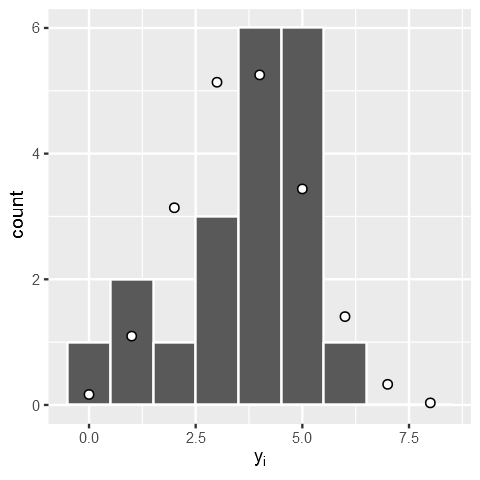

In [12]:
ggplot(data_frame(x = c(0, 8)), aes(x)) + 
    geom_histogram(data = data_frame(y = data), mapping = aes(x = y), binwidth = 1, colour = "white") + 
    stat_function(geom="point", n=9, fun = function(x, size, prob){20 * dbinom(x, size, prob)}, 
                  args = list(size = 8, prob = 0.45), shape = 21, fill = "white", size = 2) + 
    xlab(expression("y"[i]))

## 8.2 ふらふら試行錯誤による最尤推定

微分できない -> シミュレーションで近似解を求める

`q` を離散化して（0.01 -- 0.99まで，0.01きざみ），

1. 確率 1/2 で `q` を増やすか減らすかを決定し， `nq` とする
1. `nq` の対数尤度 `logL(nq)` が `logL(q)` より高いなら，`q` を`nq`に更新する

In [13]:
library("R6")

In [14]:
runif(1)

[1] 0.6261487

In [15]:
MCMC <- R6Class("MCMC",
    public = list(
        data = NULL, 
        initialize = function(data = NA) {
            self$data <- data
        }
    ), 
    private = list(
        vq = seq(0.01, 0.99, 0.01), 
        logL = function(q){
            sum(self$data * log(q) + (8 - self$data) * log(1 - q) + log(choose(8, self$data)))
        } 
    )
  
)

In [16]:
MCMC.walk <- R6Class("MCMC.walk",
    inherit = MCMC, 
    public = list(
        doMCMC = function(start, nstep){
            qs <- numeric(nstep)
            qs[1] <- start
            pL <- super$logL(start)
            for(i in c(2:nstep)){
                q_L <- private$generate_step(qs[i - 1], pL)
                qs[i] <- q_L$q
                pL <- q_L$L
            }
            return(qs)
        }
    ), 
    private = list(
        generate_step = function(q, L){
            nq <- ifelse(sample(c(TRUE, FALSE), size = 1, prob = c(0.5, 0.5)), q - 0.01, q + 0.01)
            nL <- super$logL(nq)
            if (nL > L){
                return(list(q = nq, L = nL))
            } else {
                return(list(q = q, L = L))
            }
        }
    )
  
)

In [17]:
mcmc.walk <- MCMC.walk$new(data)
mcmc.walk

<MCMC.walk>
  Inherits from: <MCMC>
  Public:
    clone: function (deep = FALSE) 
    data: 4 3 4 5 5 2 3 1 4 0 1 5 5 6 5 4 4 5 3 4
    doMCMC: function (start, nstep) 
    initialize: function (data = NA) 
  Private:
    generate_step: function (q, L) 
    logL: function (q) 
    vq: 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0. ...

In [18]:
mcmc.walk$data

[1] 4 3 4 5 5 2 3 1 4 0 1 5 5 6 5 4 4 5 3 4

100回やると，q は 0.46になった

In [19]:
mcmc.walk$doMCMC(0.3, 100) %>>% last()

[1] 0.46

初期値が異なっても，`q=0.46` になる

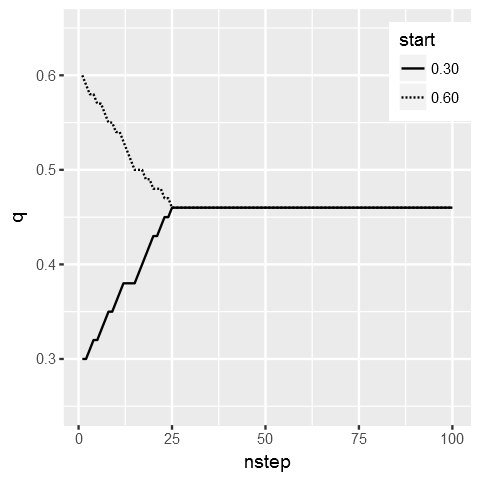

In [20]:
data_frame(nstep = c(1:100), q03 = mcmc.walk$doMCMC(0.3, 100), q06 = mcmc.walk$doMCMC(0.6, 100)) %>>% 
    gather(start, q, -nstep) %>>% 
    ggplot(aes(x = nstep, y = q, group = start, linetype = start)) + 
        geom_line() + 
        ylim(c(0.25, 0.65)) + 
        theme(
            legend.position = c(.9, .85)
        ) + 
        scale_linetype(labels = c("0.30", "0.60"))

## 8.3 メトロポリス法

`q` を離散化して（0.01 -- 0.99まで，0.01きざみ），

1. 確率 1/2 で `q` を増やすか減らすかを決定し， `nq` とする
1. `nq` の尤度 `L(nq)` が `L(q)` より高いなら，`q` を`nq`に更新する
1. `nq` の尤度 `L(nq)` が `L(q)` より低いなら，確率 `r = L(nq) / L(q)` で `q` を `nq` に更新する

In [21]:
MCMC.metropolis <- R6Class("MCMC.metropolis",
    inherit = MCMC, 
    public = list(
        doMCMC = function(start, nstep){
            qs <- numeric(nstep)
            qs[1] <- start
            pL <- super$logL(start)
            for(i in c(2:nstep)){
                q_L <- private$generate_step(qs[i - 1], pL)
                qs[i] <- q_L$q
                pL <- q_L$L
            }
            return(qs)
        } 
    ), 
    private = list(
        generate_step = function(q, L){
            nq <- ifelse(sample(c(TRUE, FALSE), size = 1, prob = c(0.5, 0.5)), q - 0.01, q + 0.01)
            nL <- super$logL(nq)
            if (nL > L){
                return(list(q = nq, L = nL))
            } else {
                r <- exp(nL - L)
                if(sample(c(0, 1), size = 1, prob = c(r, 1 - r)) == 0){
                    return(list(q = nq, L = nL))

                } else {
                    return(list(q = q, L = L))            
                }
            }
        }    
    ) 
)

In [22]:
mcmc.metropolis <- MCMC.metropolis$new(data)
mcmc.metropolis

<MCMC.metropolis>
  Inherits from: <MCMC>
  Public:
    clone: function (deep = FALSE) 
    data: 4 3 4 5 5 2 3 1 4 0 1 5 5 6 5 4 4 5 3 4
    doMCMC: function (start, nstep) 
    initialize: function (data = NA) 
  Private:
    generate_step: function (q, L) 
    logL: function (q) 
    vq: 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0. ...

In [23]:
mcmc.metropolis$doMCMC(0.3, 10)

[1] 0.30 0.30 0.31 0.32 0.32 0.33 0.32 0.32 0.33 0.33

メトロポリス法 100 step

In [24]:
library(gridExtra)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [25]:
options(repr.plot.width = 10, repr.plot.height = 3)

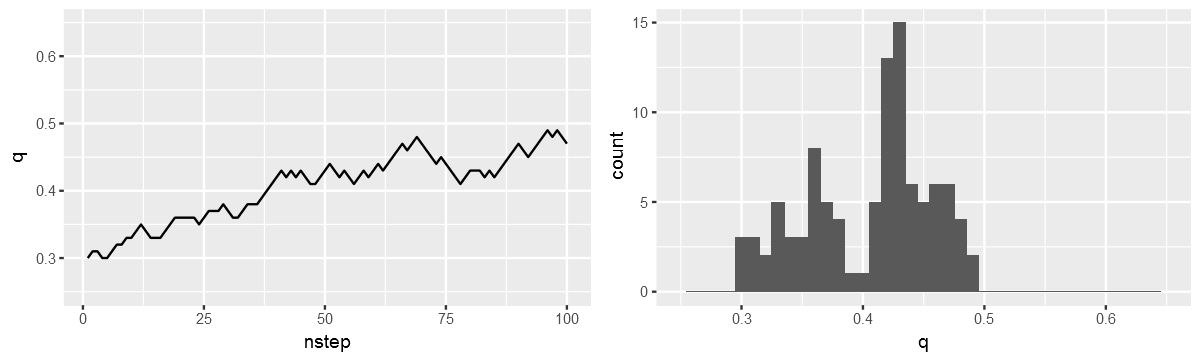

In [26]:
d.met1 <- data_frame(
    nstep = c(1:100), 
    q = mcmc.metropolis$doMCMC(0.3, 100)
)
gp1 <- ggplot(data = d.met1, aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = d.met1, aes(x = q)) + geom_histogram(binwidth = 0.01) + xlim(c(0.25, 0.65))
grid.arrange(gp1, gp2, ncol = 2)

メトロポリス法 1000 step

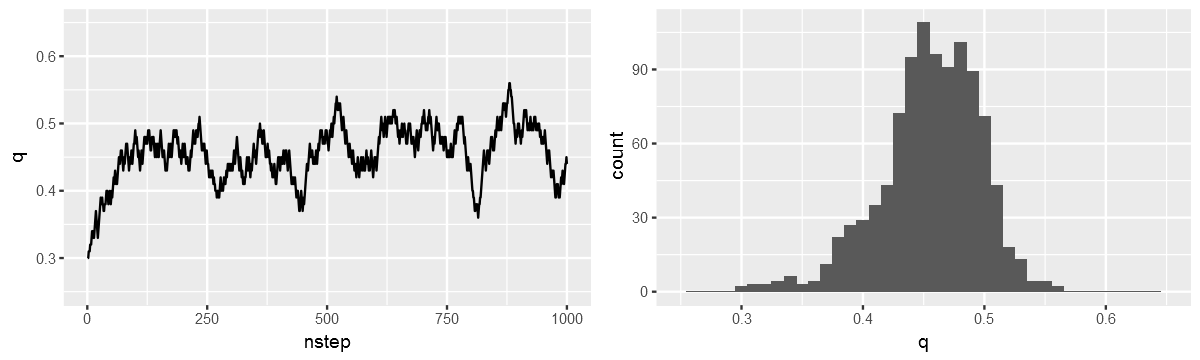

In [27]:
d.met2 <- data_frame(
    nstep = c(1:1000), 
    q = mcmc.metropolis$doMCMC(0.3, 1000)
)
gp1 <- ggplot(data = d.met2, aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = d.met2, aes(x = q)) + geom_histogram(binwidth = 0.01) + xlim(c(0.25, 0.65))
grid.arrange(gp1, gp2, ncol = 2)

メトロポリス法 100000 step （100 step ごと）

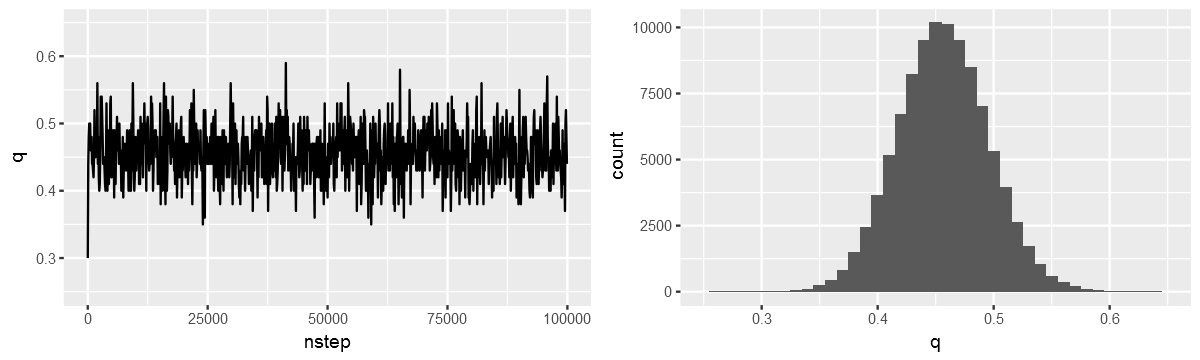

In [28]:
d.met3 <- data_frame(
    nstep = c(1:100000), 
    q = mcmc.metropolis$doMCMC(0.3, 100000)
)
gp1 <- ggplot(data = slice(d.met3, seq(1, 100000, 100)), aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = d.met3, aes(x = q)) + geom_histogram(binwidth = 0.01) + xlim(c(0.25, 0.65))
grid.arrange(gp1, gp2, ncol = 2)

### 8.3.2 マルコフ連鎖の定常分布

ある変数 $q$ のマルコフ連鎖が一定の条件を満たしているとき，そのマルコフ連鎖から発生する$q$の値はある確率分布（定常分布）に従う

初期値に関わらず，十分長いstep数をとれば，$q$は定常分布に従う

In [29]:
d.met4 <- data_frame(
    nstep = c(1:500), 
    q1 = mcmc.metropolis$doMCMC(0.1, 500), 
    q3 = mcmc.metropolis$doMCMC(0.3, 500), 
    q4 = mcmc.metropolis$doMCMC(0.4, 500), 
    q45 = mcmc.metropolis$doMCMC(0.45, 500),    
    q5 = mcmc.metropolis$doMCMC(0.5, 500), 
    q6 = mcmc.metropolis$doMCMC(0.6, 500), 
    q7 = mcmc.metropolis$doMCMC(0.7, 500) 
)

In [30]:
options(repr.plot.width = 8, repr.plot.height = 4)

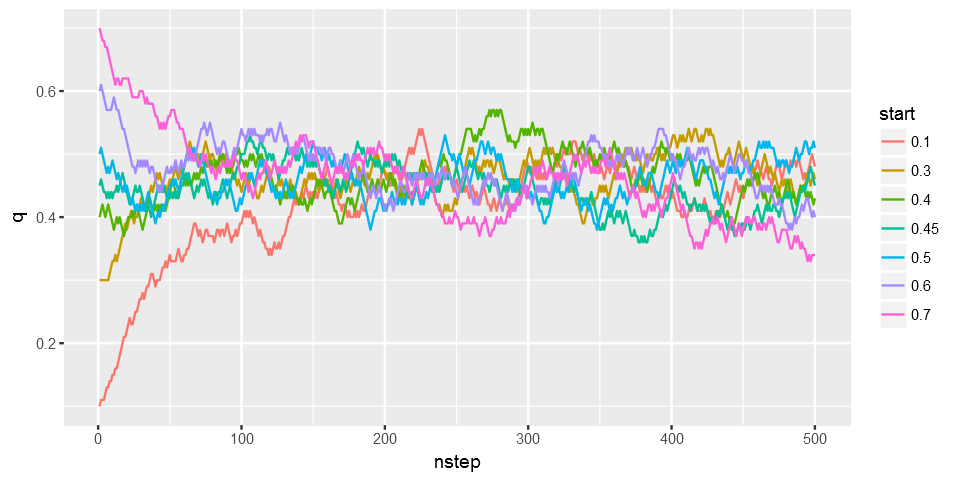

In [31]:
d.met4 %>>% gather(start, q, -nstep) %>>% 
    ggplot(aes(x = nstep, y = q, group = start, colour = start)) + 
    geom_line() + 
    scale_colour_discrete(labels = c("0.1", "0.3", "0.4", "0.45", "0.5", "0.6", "0.7")) 

### 8.3.3 この定常分布は何を表す分布なのか?

この例題では，定常分布 $p(q | \boldsymbol{Y})$ は 尤度 $L(q)$ に比例する確率分布で，

$$ p(q | \boldsymbol{Y}) = \frac{L(q)}{\sum\limits_q L(q)} $$

定常分布を返す関数を `MCMC.metropolis` class に追加する

In [32]:
MCMC.metropolis$set("public", "st.dist", function(){
    vlogL <- sapply(private$vq, function(x){super$logL(x)})
    data_frame(vq = private$vq, st.dist = exp(vlogL) / sum(exp(vlogL)))
})
MCMC.metropolis

<MCMC.metropolis> object generator
  Inherits from: <MCMC>
  Public:
    doMCMC: function (start, nstep) 
    clone: function (deep = FALSE) 
    st.dist: function () 
  Private:
    generate_step: function (q, L) 
  Parent env: <environment: R_GlobalEnv>
  Locked objects: TRUE
  Locked class: FALSE
  Portable: TRUE

In [33]:
mcmc.metropolis.st <- MCMC.metropolis$new(data)
dd <- mcmc.metropolis.st$st.dist()

`q` のヒストグラムを密度にする関数

In [34]:
met.freq.q <- function(vq, q){
    lcount <- hist(q, breaks = seq(min(vq) - 0.01 * 0.5, max(vq) + 0.01 * 0.5, 0.01), plot = FALSE)$count
    data_frame(vq, dens = lcount / sum(lcount))
}

In [35]:
options(repr.plot.width = 10, repr.plot.height = 3)

Warning message:
"Removed 58 rows containing missing values (position_stack)."Warning message:
"Removed 58 rows containing missing values (geom_path)."

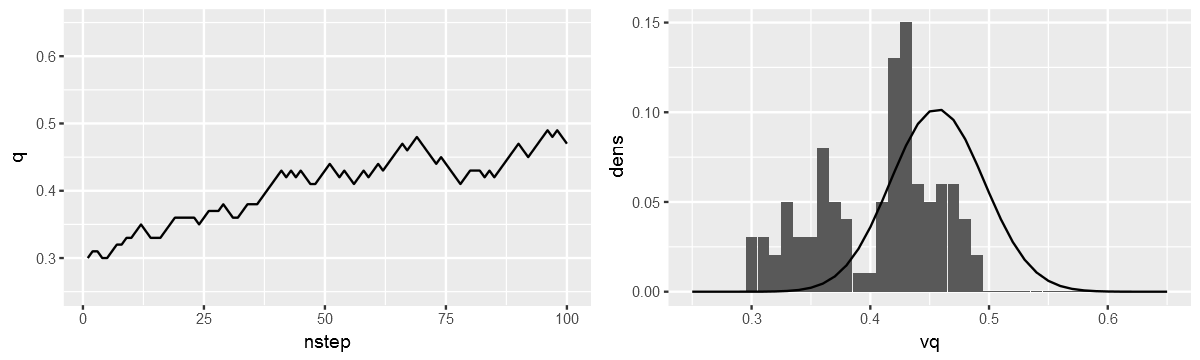

In [36]:
gp1 <- ggplot(data = d.met1, aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = met.freq.q(seq(0.01, 0.99, 0.01), d.met1$q), aes(x = vq, y = dens)) + 
    geom_bar(stat = "identity") + 
    geom_line(data = dd, mapping = aes(x = vq, y = st.dist)) + 
    xlim(c(0.25, 0.65))
grid.arrange(gp1, gp2, ncol = 2)

Warning message:
"Removed 58 rows containing missing values (position_stack)."Warning message:
"Removed 58 rows containing missing values (geom_path)."

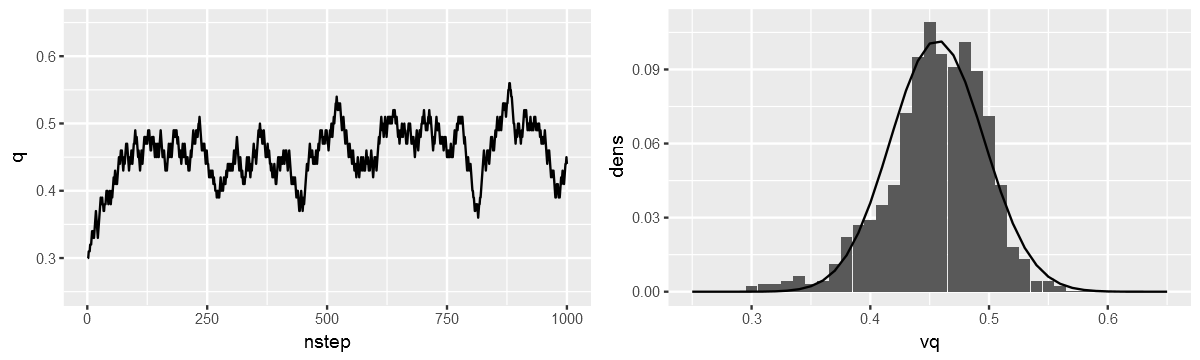

In [37]:
gp1 <- ggplot(data = d.met2, aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = met.freq.q(seq(0.01, 0.99, 0.01), d.met2$q), aes(x = vq, y = dens)) + 
    geom_bar(stat = "identity") + 
    geom_line(data = dd, mapping = aes(x = vq, y = st.dist)) + 
    xlim(c(0.25, 0.65))
grid.arrange(gp1, gp2, ncol = 2)

Warning message:
"Removed 58 rows containing missing values (position_stack)."Warning message:
"Removed 58 rows containing missing values (geom_path)."

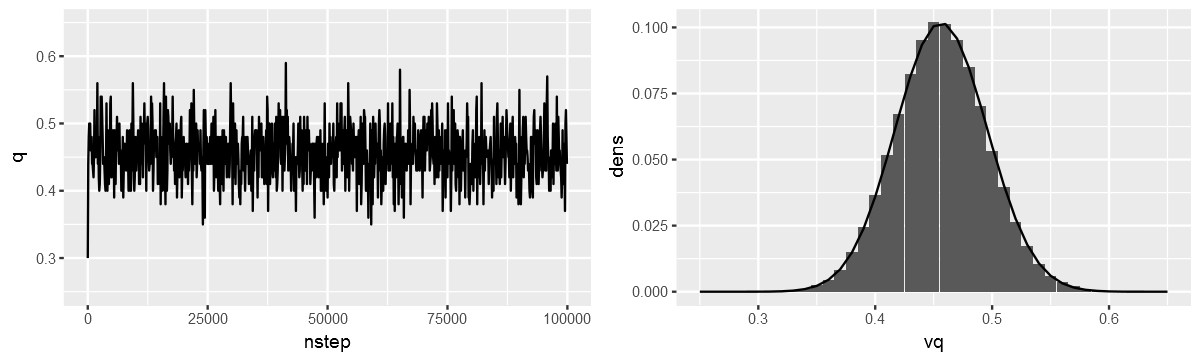

In [38]:
gp1 <- ggplot(data = slice(d.met3, seq(1, 100000, 100)), aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = met.freq.q(seq(0.01, 0.99, 0.01), d.met3$q), aes(x = vq, y = dens)) + 
    geom_bar(stat = "identity") + 
    geom_line(data = dd, mapping = aes(x = vq, y = st.dist)) + 
    xlim(c(0.25, 0.65))
grid.arrange(gp1, gp2, ncol = 2)

## 8.4 MCMCサンプリングとベイズ統計モデル
例題をベイズ統計モデルとして考えてみる

ベイズの定理

$$ p(B | A) = \frac{p(A|B)p(B)}{p(A)} $$

* $p(B)$: 事象$A$が起こる前の事象$B$の確率（事前確率）
* $p(B|A)$: 事象$A$がおきた後の事象$B$ の確率（事後確率）

条件付確率の定義より， $p(B|A)$，$p(A|B)$ はそれぞれ次のように書ける

$$ p(B|A) = \frac{p(B, A)}{p(A)} $$
$$ p(A|B) = \frac{p(A, B)}{p(B)} $$

$p(A, B) = p(B, A) $ なので

$$ p(B|A) \times p(A) = p(A|B) \times p(B) $$

したがって，

$$ p(B | A) = \frac{p(A|B)p(B)}{p(A)} $$

データ$\boldsymbol{Y}$ が得られた時の種子の生存確率$q$が知りたい: $p(q|\boldsymbol{Y})$（事後確率） 

ベイズの定理に当てはめると，

$$ p(q|\boldsymbol{Y}) = \frac{p(\boldsymbol{Y} | q) p(q)}{p(\boldsymbol{Y})}$$

* $p(\boldsymbol{Y}|q)$: ある生存確率$q$のもとでデータ$\boldsymbol{Y}$が得られる確率: 尤度 $L(q)$
* $p(q)$: データ$\boldsymbol{Y}$がない時の$q$の確率分布（事前分布，不明）
* $p(Y)$: $q$ がないときに $\boldsymbol{Y}$ が得られる確率．つまり，すべての$q$についての$p(\boldsymbol{Y}, q)$の和で，

$$
\begin{align}
p(\boldsymbol{Y}) &= \sum\limits_q p(\boldsymbol{Y}, q) \\ 
    &= \sum\limits_q p(\boldsymbol{Y} | q) \times p(q) \\
    &= \sum\limits_q L(q) \times p(q)
\end{align}
$$

したがって，

$$ 
\begin{align}
p(q|\boldsymbol{Y}) &= \frac{p(\boldsymbol{Y} | q) p(q)}{p(\boldsymbol{Y})} \\
    &= \frac{L(q) p(q)}{\sum\limits_q L(q) p(q)}
\end{align}
$$


つまり，事後分布は，

$$ p(q|\boldsymbol{Y}) \propto L(q) p(q) $$

となっている．
いま，定常分布は，

$$ \frac{L(q)}{\sum\limits_q L(q)} \propto L(q) $$

なので，$ p(q)$ = （定数）なら求めたい事後分布がMCMCサンプリングによって得られたということになる．

## 8.5 補足説明
### 8.5.1 メトロポリス法と定常分布の関係

メトロポリス法で得られた$q$のサンプルが定常分布$p(q|\boldsymbol{Y})$からのランダムサンプリングであるためには以下の二つの条件が成立していなければならない

* $q$が任意の初期値から定常分布 $p(q | \boldsymbol{Y})$ に収束する（エルゴード条件）
* ある$q$が$p(q | \boldsymbol{Y})$にしたがっていて，メトロポリス法で$nq$ を得たときに，$nq$ も$p(q | \boldsymbol{Y})$にしたがっている（詳細釣り合いの条件）

$$ p(q | \boldsymbol{Y}) p(q \rightarrow nq) = p(nq | \boldsymbol{Y}) p(nq \rightarrow q) $$

今回の場合は両条件ともに成立している

#### 詳細釣り合いの条件の確認
* $L(q) < L(nq)$ のとき
$$ p(q \rightarrow nq) = 0.5 \times 1$$
$$ p(nq \rightarrow q) = 0.5 \times \frac{L(nq)}{L(q)} $$

両辺割って，整理すると，

$$ L(nq) p(nq \rightarrow q) = L(q) p(q \rightarrow nq) $$

定常分布が 

$$ p(q | \boldsymbol{Y}) = \frac{L(q)}{\sum\limits_q L(q)}  $$

であることを用いると，

$$ p(nq | \boldsymbol{Y}) p(nq \rightarrow q) = p(q | \boldsymbol{Y})p(q \rightarrow nq) $$

* $L(nq) < L(q)$ のとき

$$ p(q \rightarrow nq) = 0.5 \times \frac{L(nq)}{L(q)} $$
$$ p(nq \rightarrow q) = 0.5 \times 1 $$

であり，同様に，

$$ p(nq | \boldsymbol{Y}) p(nq \rightarrow q) = p(q | \boldsymbol{Y})p(q \rightarrow nq) $$


#### 詳細釣り合いの条件を満たす推移確率ならば定常分布に収束するかどうか

定常分布 × 推移確率 = 定常分布なら収束しているが，

$$
\begin{align}
p(q | \boldsymbol{Y}) &= \sum\limits_q p(q \rightarrow nq) \times p(nq | \boldsymbol{Y}) \\
    &= \sum\limits_{nq} p(nq \rightarrow q) \times p(q | \boldsymbol{Y}) \\
    &= 1 \times p(q | \boldsymbol{Y}) \\
    &= p(q | \boldsymbol{Y})
\end{align}
$$

となり，これは成り立つ．

定常分布がわかっている場合，詳細釣り合いの条件を満たすように推移確率を決めれば，定常分布に収束させることができる．

定常分布が$ p(x) $のとき，メトロポリス法の推移確率は，

$$ \prod_{x \rightarrow x'} = \mathrm{min} \left(1, \frac{p(x')}{p(x)} \right)$$

であり，いま，定常分布が $\frac{L(q)}{\sum\limits_q L(q)}$ なので，推移確率は，

$$ \mathrm{min}\left(1, \frac{\frac{L(nq)}{\sum\limits_q L(q)}}{\frac{L(q)}{\sum\limits_q L(q)}} \right) =  \mathrm{min}\left(1, \frac{L(nq)}{L(q)} \right) $$

となる

## 8.6 まとめ

* 最尤推定法は尤度最大となるパラメータを探索する
* MCMCアルゴリズムは定常分布からのランダムサンプリング
* ベイズ統計モデルで考えると，定常分布は事後分布とみなせる

## 参考資料
* [可視化で理解するマルコフ連鎖モンテカルロ法(MCMC)](http://d.hatena.ne.jp/hoxo_m/20140911/p1)
* [http://bin.t.u-tokyo.ac.jp/summercamp2015/document/prml11_chika.pdf]()
* [http://www.smapip.is.tohoku.ac.jp/~smapip/2003/tutorial/textbook/koji-hukushima.pdf]()

In [39]:
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.2 (2016-10-31)
 system   x86_64, mingw32             
 ui       RTerm                       
 language (EN)                        
 collate  Japanese_Japan.932          
 tz       Asia/Tokyo                  
 date     2016-11-24                  

 package    * version date       source                            
 assertthat   0.1     2013-12-06 CRAN (R 3.2.1)                    
 Cairo        1.5-9   2015-09-26 CRAN (R 3.2.2)                    
 colorspace   1.2-7   2016-10-11 CRAN (R 3.3.2)                    
 crayon       1.3.2   2016-06-28 CRAN (R 3.3.1)                    
 DBI          0.5-1   2016-09-10 CRAN (R 3.2.5)                    
 devtools     1.12.0  2016-06-24 CRAN (R 3.3.1)                    
 digest       0.6.10  2016-08-02 CRAN (R 3.3.1)                    
 dplyr      * 0.5.0   2016-06-24 CRAN (R 3.2.5)                    
 evaluate     0.10    2016-10-11 CRAN (R 3.3.2)                    
 ggplot